In [0]:
# Данный код монтирует гугл диск к директории /gdrive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, ensemble, metrics, manifold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import xgboost as xgb


import lightgbm as lgb
%pylab inline



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
import warnings
from sklearn.utils import shuffle
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [0]:
#загрузить данные
train = pd.read_csv('/gdrive/My Drive/DATA/Stepik/orange_small_churn_data.train')
test = pd.read_csv('/gdrive/My Drive/DATA/Stepik/orange_small_churn_test_data.csv')

In [0]:
#выделю метки и из тренировочного данного удалю колонки незадейственные в анализе
train_data = train.drop(['ID', 'labels'], axis=1)
test_data = test.drop(['ID'], axis=1)
labels = train['labels']

In [0]:
#функция для кодирования категориальных признаков
def labelEncoder(data):
    le = LabelEncoder()
    for m in range(190,230):
        #print(m)
        tmp = data.iloc[:,m].astype(str)
        le.fit(tmp)
        data.iloc[:,m] = le.transform(tmp)        
    return data

In [0]:
def dropUninformCol(data):
  df = pd.DataFrame()
  df = data.dropna(axis=1, how='all')
  return df

In [0]:
def undersampling(x_train, y_train, alpha=0.5):
  over_1 = RandomUnderSampler(sampling_strategy=alpha)
  X, y = over_1.fit_resample(x_train, y_train)
  return X, y

In [0]:
def get_estimator():
    return xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1)

In [0]:
def base_model(est, nX, ny, cost_of_retention, per_cent, accepted_probability, mean_revenue):
    values = est.predict_proba(nX)[:,1]
    nvl = sorted([(value, ny[idx], idx) for (idx, value) in enumerate(values)],
                 key = lambda x: -x[0])
    cnt = int((per_cent / 100.) * len(nvl))
    nvl = nvl[:cnt]
    to_spend = len(nvl) * cost_of_retention
    earn = 0
    for element in nvl:
        if element[1] == 1:
            earn += accepted_probability * mean_revenue
    return earn - to_spend


In [0]:
x_test_le = labelEncoder(test_data.iloc[:,:230])
x_test_col = x_test_le.dropna(axis=1, how='all')
X_median_test = x_test_col.fillna(x_data_col.median(axis=0))

In [0]:
values = est.predict_proba(X_median)[:,1]

In [0]:
values

array([0.06316517, 0.08043093, 0.02842955, ..., 0.04143121, 0.04182533,
       0.07881754], dtype=float32)

In [0]:
nvl = sorted([(value, labels[idx], idx) for (idx, value) in enumerate(values)],
                 key = lambda x: -x[0])

In [0]:
def economic_model(y_true, predicted, top, incomeFor1, costFor1, randomChance):
    df_clients = pd.DataFrame([])
    df_clients['predict'] = predicted
    df_clients['y_true'] = y_true
    df_clients['profit'] = 0
    np.random.seed(27)
    rands = pd.DataFrame(data = np.random.random(len(predicted)), columns=['random'])
    df_clients.sort_values('predict', inplace = True, ascending=False)
    threshold = df_clients.iloc[int(len(df_clients)*top)-1, 0]
    profit = 0
    
    df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == 1)].index] = 0
    df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == -1)].index] = incomeFor1 
    df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == 1)][(rands['random']>randomChance)].index]= 0-costFor1
    df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == 1)][(rands['random']<randomChance)].index]= incomeFor1-costFor1 
    df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == -1)].index] = incomeFor1-costFor1
    
    profit = sum(df_clients['profit'])
    
    statistic = stats(df_clients, top, profit, incomeFor1, costFor1, 0.2, randomChance)
    return profit, df_clients, statistic

In [0]:
def plot_income(y_true, predicted, incomeFor1, costFor1, randomChance):
    tops = np.linspace(0.005,1., num = 200)
    incomes = []
    statistic = pd.DataFrame([])
    for top in tops:
        incomes.append(economic_model(y_true, predicted, top, incomeFor1, costFor1, randomChance)[0])
        statistic=statistic.append(economic_model(y_true, predicted, top, incomeFor1, costFor1, randomChance)[2], ignore_index=True)
    plt.figure(figsize=(20,10))
    plt.title(u"график зависимости полученной прибыли от топа прогнозируемых клиентов после проведения кампании по удержанию")
    plt.xlabel("Top")
    plt.ylabel("Profit")
    plt.plot(tops, incomes, color="g", label=u"прибыль с учетом прогноза оттока")
    plt.plot(tops[0], incomes[0], 'ro', label = u'соответствует значению без удержания клиентов')
    plt.plot(tops[-1], incomes[-1], 'bo', label = u'соответствует значению после опроса всех клиентов')
    df = pd.DataFrame([])
    df['Profit'] = incomes
    df['Top'] = tops
    plt.legend(loc="best")
    return df, statistic

In [0]:
def stats(df, top, profit, incomeFor1, costFor1, churn, chance):
    temp = pd.DataFrame([[top,
                        len(df)*(1-churn)*incomeFor1,
                        len(df)*1.*(incomeFor1-costFor1) - len(df)*churn*(incomeFor1)*(1-chance),
                        profit,
                        len(df),
                        int(len(df)*(1-churn)),
                        len(df[df['profit']>0]),
                        len(df)*incomeFor1*0.8,
                        len(df[df['profit']>0])*incomeFor1]],
                        columns=['top of predicted clients',
                                'profit without anything',
                                'profit with all called clients',
                                'profit with predicted clients',
                                'number of clients before predict',
                                'number of clients after no predict',
                                'number of clients after predict',
                                'profit in next time(no predict, next month with action)',
                                'profit in next time(predict, next month with action)'])
    return temp

In [0]:
def plot_stats(df):
    plt.figure(figsize=(20,10))
    plt.title(title)
    plt.xlabel("Top")
    plt.ylabel("Profit")
    plt.plot(df.iloc[:,0], df.iloc[:,1], '--', color="r", label=u"прибыль с 20% оттока")
    plt.plot(df.iloc[:,0], df.iloc[:,2], '--',color="k", label=u"прибыль с учетом обзвона всех клиентов")
    plt.plot(df.iloc[:,0], df.iloc[:,3],color="g", label=u"прибыль с учетом прогноза оттока")
    plt.plot(df.iloc[:,0], df.iloc[:,8],color="b", label=u"прибыль в будущем(после прогноза и затрат)")
    plt.title(u"график зависимости полученной прибыли от топа прогнозируемых клиентов после проведения кампании по удержанию")
    plt.legend(loc="best")

In [0]:
import copy
def plot_year_prediction(stats, stats2, increase_percent, predict, costFor1, chance1, income):
    
    columns=['top of predicted clients',
            'increase clients (no predict)',
            'increase clients (predict)',
            'increase clients (all called)',
            'profit (year, no predict)',
            'profit (year, predict)',
            'profit (year, all called)']
    df = pd.DataFrame(columns = columns)
    increase_plan = (1.+increase_percent)*len(predict)
    print (increase_plan)
    for i in range(len(stats)):
        sample = [
            stats.iloc[i,0],
            increase_plan - stats.iloc[i,5],
            increase_plan - stats.iloc[i,6],
            increase_plan - stats.iloc[i,4],
            stats.iloc[i,1],
            stats.iloc[i,3],
            stats.iloc[i,2]
        ]
        
        first_month = copy.copy(sample)
        second_month = [
            stats.iloc[i,0],
            increase_plan - stats2.iloc[i,5],
            increase_plan - stats2.iloc[i,6],
            increase_plan - stats2.iloc[i,4],
            stats2.iloc[i,1],
            stats2.iloc[i,3],
            stats2.iloc[i,2]
        ]
        sample[4] += (first_month[4] - (((sample[1]/chance1)*costFor1)/12) + (((sample[1]*income)*(1))/12))
        sample[5] += (first_month[5] - (((sample[2]/chance1)*costFor1)/12) + (((sample[2]*income)*(1))/12))
        sample[6] += (first_month[6] - (((sample[3]/chance1)*costFor1)/12) + (((sample[3]*income)*(1))/12))
        for month in range(10):
            sample[4] += (second_month[4] - (((sample[1]/chance1)*costFor1)/12) + (((sample[1]*income)*(month+2))/12))
            sample[5] += (second_month[5] - (((sample[2]/chance1)*costFor1)/12) + (((sample[2]*income)*(month+2))/12))
            sample[6] += (second_month[6] - (((sample[3]/chance1)*costFor1)/12) + (((sample[3]*income)*(month+2))/12))
        temp_df = pd.DataFrame(data = [sample], columns=columns)
        df = df.append(temp_df)
        
    plt.figure(figsize=(20,10))
    plt.title(title)
    plt.xlabel("Top")
    plt.ylabel("Profit")
    plt.plot(df.iloc[:,0], df.iloc[:,4],color="r", label=u'profit (year, no predict)')
    plt.plot(df.iloc[:,0], df.iloc[:,5],color="g", label=u'profit (year, predict)')
    plt.plot(df.iloc[:,0], df.iloc[:,6],color="b", label=u'profit (year, all called)')
    plt.title(u"график зависимости полученной прибыли за год от топа прогнозируемых клиентов после проведения кампании по удержанию")
    plt.legend(loc="best")
    return df

1. Введите еще несколько параметров и на их основе постройте простую экономическую модель: формулу по которой в зависимости от значения исходных параметров вы сможете рассчитать экономический эффект от проведения кампании (= сколько денег вы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование вашей модели.

In [0]:
x_data_le = labelEncoder(train_data.iloc[:,:230])
x_data_col = x_data_le.dropna(axis=1, how='all')
X_median = x_data_col.fillna(x_data_col.median(axis=0))

In [0]:
labels = train['labels'].fillna(-1)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X_median, labels, test_size = 0.25, random_state = 28)

In [0]:
print(Counter(y_train))

Counter({-1.0: 12676, 1.0: 1048})


In [0]:
print(Counter(y_test))

Counter({-1.0: 4246, 1.0: 329})


In [0]:
over_1 = RandomUnderSampler(sampling_strategy=0.5)
X_1, y_1 = over_1.fit_resample(x_train, y_train)
print(Counter(y_1))

Counter({-1.0: 2096, 1.0: 1048})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
print(Counter(y_test))
over_2 = RandomUnderSampler(sampling_strategy=0.5)
X_2, y_2 = over_2.fit_resample(x_test, y_test)
print(Counter(y_2))

Counter({-1.0: 4246, 1.0: 329})
Counter({-1.0: 658, 1.0: 329})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
est = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1)

est.fit(X_1, y_1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
predicted = est.predict_proba(X_2)[:,1]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


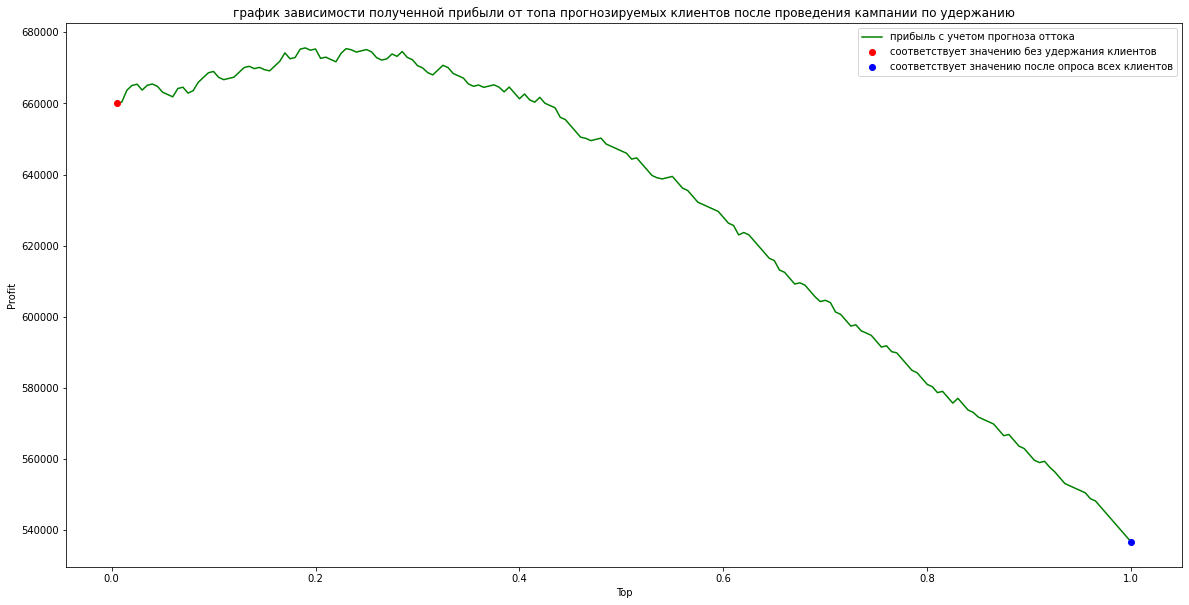

In [0]:
incomeFor1 = 1000.
costFor1 = 130 + 0.20*incomeFor1
randomChance = 0.60
statistic = plot_income(y_2, predicted, incomeFor1, costFor1, randomChance)[1]

In [0]:
tops = np.linspace(0.005,1., num = 200)

In [0]:
for top in tops:
  economic_model(y_2, predicted, top, incomeFor1, costFor1, randomChance)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


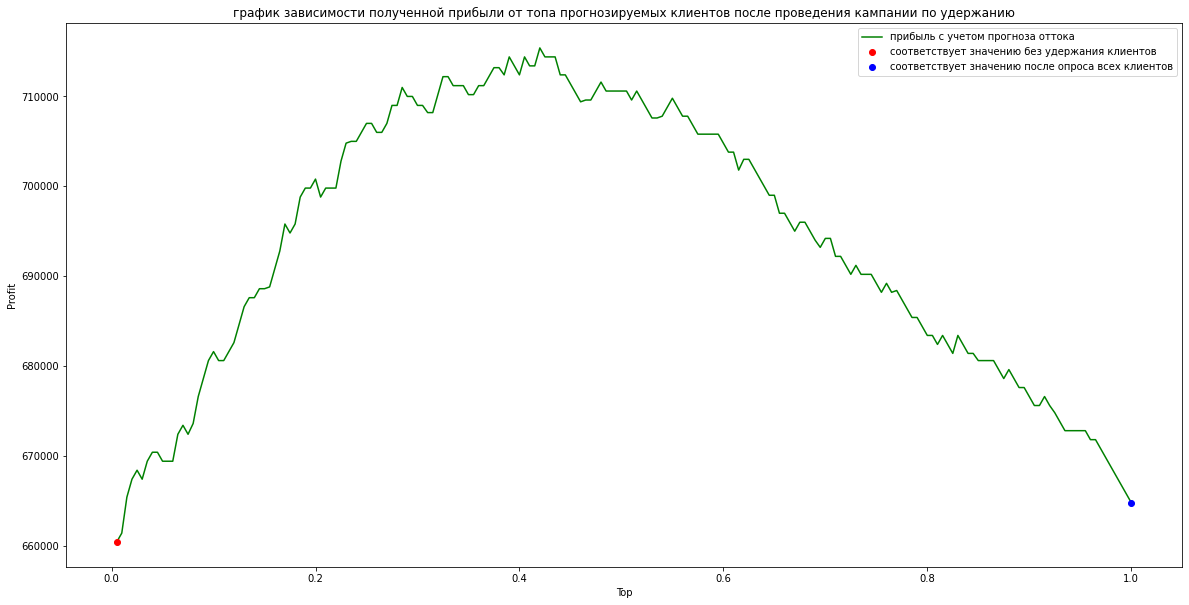

In [0]:
# понадобится в будущем
statistic_second_month = plot_income(y_2, predicted, incomeFor1, costFor1-130, randomChance)[1]



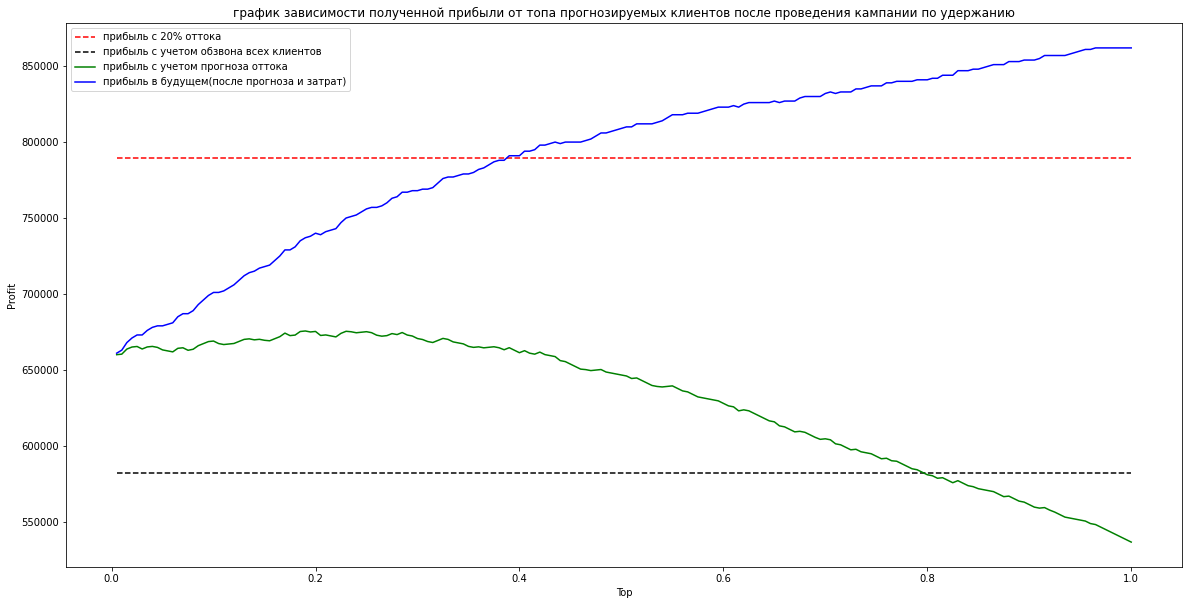

In [0]:
plot_stats(statistic)

### 2. Размер оптимального топа около 40% (видно на графиках выше). При таких значениях экономический эффект наибольший

### 3. Усложним модель, попробуем посчитаем прибыль на год вперед после проведения кампании по удержани

1085.7


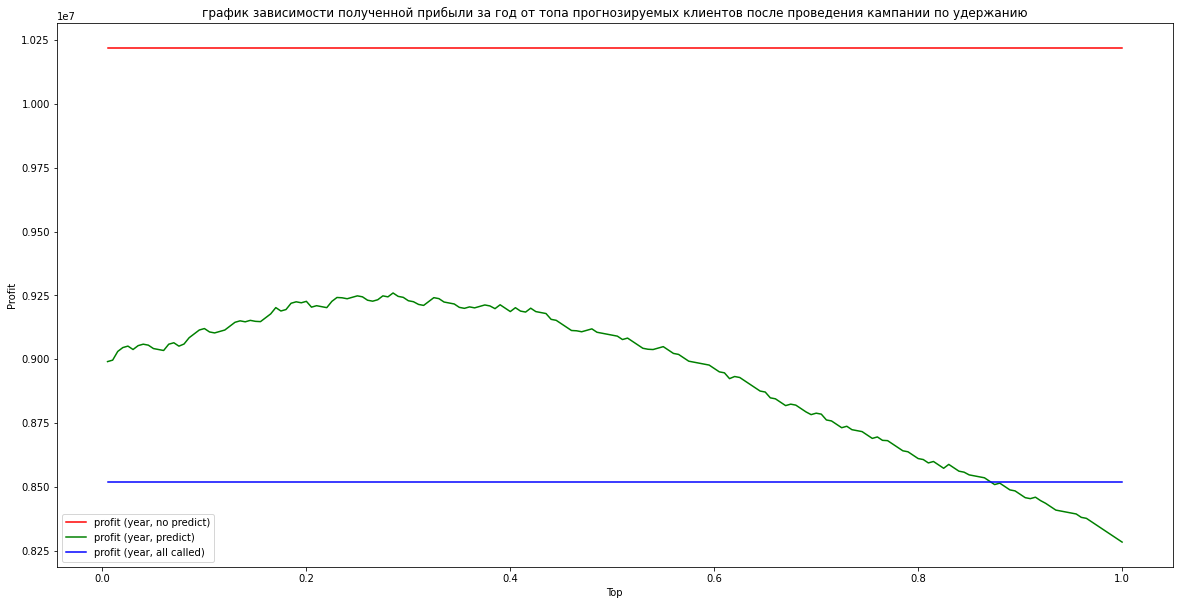

In [0]:
profit_year = plot_year_prediction(statistic,statistic_second_month, 0.1, predicted, 130, 0.5, 500)

In [0]:
print ('максимальная годовая прибыль после проведения единоразовой кампании по удержанию клиентов: '+ str(max(profit_year.iloc[:,4])))
print ('максимальная годовая прибыль без проведения единоразовой кампании по удержанию клиентов: '+ str(max(profit_year.iloc[:,5])))
print ('максимальная годовая прибыль после предложения удержания всех клиентов: '+ str(max(profit_year.iloc[:,6])))

максимальная годовая прибыль после проведения единоразовой кампании по удержанию клиентов: 10220411.5
максимальная годовая прибыль без проведения единоразовой кампании по удержанию клиентов: 9259668.166666666
максимальная годовая прибыль после предложения удержания всех клиентов: 8518961.5


### 4. Применение экономической модели становится неоправданным в том случае, когда затраты на удержание становятся слишком большими, например:

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


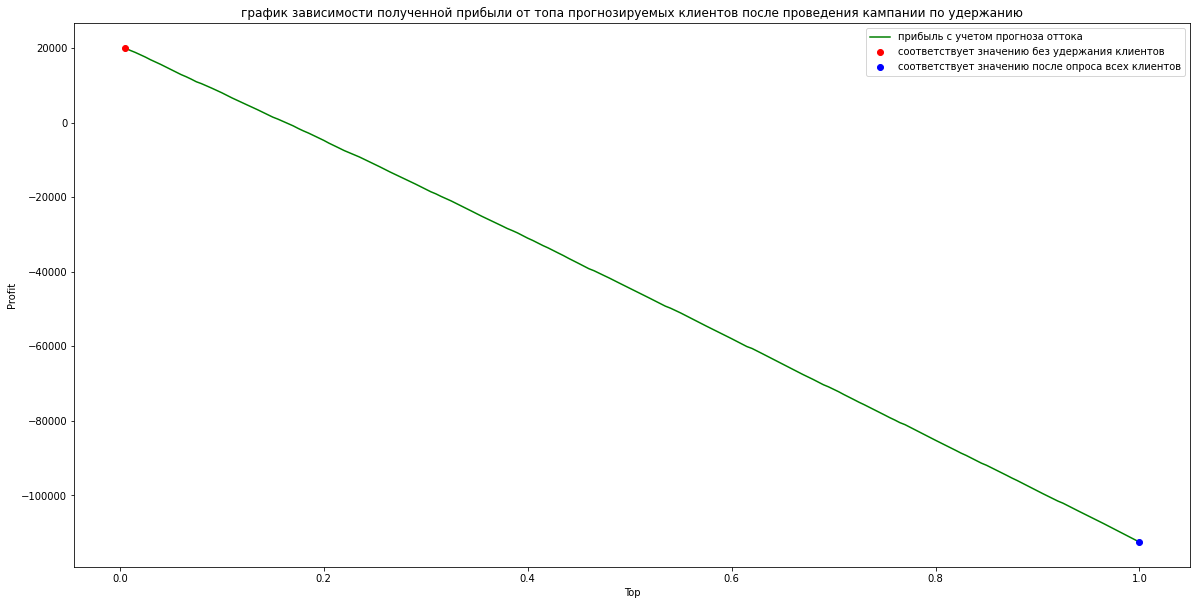

In [0]:
# увеличим затраты на связь с клиентом
incomeFor1 = 31.
costFor1 = 130 + 0.20*incomeFor1 + 5
randomChance = 0.60
statistic = plot_income(y_2, predicted, incomeFor1, costFor1, randomChance)[1]

### 5. При увеличении качества модели на 1-3% экономический эффект будет небольшим или вовсе не будет, так как качество оценивалось по метрике AUC ROC. Для этой метрики увеличение качества может значить, что уверенность алгоритма в правильно классифицируемых объектах стала болше, а количество ошибок первого/второго рода осталось таким же, следовательно экономического эффекта может не быть вовсе. Для увеличения экономического эффекта нужно работать над уменьшением количества ошибок первого/второго рода.

### 6. Вложение средств может быть оправданным только в том случае, когда модель будет давать меньше ошибок первого/второго рода. Нужно оценить прибыль от увеличения качества классификации и затраты на увеличение качества модели, только тогда можно судить о вложении средств в увеличение качества модели.